# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
2.1     | 30/09/2022 | H.A.       | Use df_for_Anomaly_prediction.pkl as data source 
1.0     | 24/08/2022 | H.A.       | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Loads the raw and pre-processed Narrative data once tokenized and stemmed ("Narrative_Raw_Stemmed_24072022_TRAIN.pkl" and "Narrative_PP_stemmed_24072022_TRAIN.pkl") (cf 03_Narr_Next preprocessing 20220721.ipynb)

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly

* Performs Anomaly target feature prediction : Bag Of Words approach with feature selection based on feature importance 

# IMPORT PACKAGES


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer
##############################
# Undersampeling
##############################
from imblearn.under_sampling import RandomUnderSampler 
###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD DATA

## Mount GDrive

In [2]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [3]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [4]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 2022_09_11_7_4_3_raw_narr_BERT_BASE_frozen_max_length_345.pkl
 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 logs
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [5]:
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96986 entries, 1163382 to 874642
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     96986 non-null  object
 1   Anomaly                                       96986 non-null  object
 2   Narrative_PP_stemmed                          96986 non-null  object
 3   Narrative_Raw_Stemmed                         96986 non-null  object
 4   Narrative_Raw_Stemmed_str                     96986 non-null  object
 5   Narrative_PP_stemmed_str                      96986 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  96986 non-null  int64 
 7   Anomaly_Aircraft Equipment                    96986 non-null  int64 
 8   Anomaly_Conflict                              96986 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            96986 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [7]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [8]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# SUPERVISED NARRATIVE PREPROCESSING WITH IMPORTANCE


## FIRST DECISION TREE PREDICTION

## STANDARD SAMPLING - Function metrics_table_DT  (DT classifiers only)
-Performs a decision tree model with standard sampling on the different targets and stock the results as well as the importance of features (tokens)

In [9]:
def metrics_table_DT(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    df_importances = pd.DataFrame(vocab).rename(columns={0: 'token'})
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
     
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)

      #########  FEATURE IMPORTANCE ################
      # write feature and its importance into a dict
      feats={}
      for feature,importance in zip(vocab, classifier.feature_importances_):
        feats[feature] = importance

      # Create a DataFrame from the dict. Each anomaly label gets a new column
      col_importance = 'Importance_' + Anomaly
      importance = pd.DataFrame.from_dict(feats, orient = 'index').reset_index().rename(columns = {'index': 'token', 0: col_importance})
      df_importances = df_importances.merge(importance, on = 'token', how = 'left')

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp, df_importances

### DT (Gini , Max_Depth=20), PP NARRATIVES,DEFAULT SAMPLING  (df_metrics_DT_PP.pkl)

In [10]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [11]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 50030
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 5.1 minutes ---


In [12]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [13]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
filename = 'df_metrics_DT_PP.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


####Token Importance analysis

In [14]:
len(df_importances)

50030

In [15]:
df_metrics[df_metrics['metric'] == 'f1-score']

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
2,Decision Tree,1,0,NaN,Anomaly_Deviation / Discrepancy - Procedural,f1-score,0.545333,0.759770,0.685638,0.652551,0.674130
6,Decision Tree,1,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.868409,0.784982,0.836736,0.826696,0.835439
10,Decision Tree,1,0,NaN,Anomaly_Conflict,f1-score,0.926633,0.634048,0.877771,0.780341,0.874385
14,Decision Tree,1,0,NaN,Anomaly_Inflight Event / Encounter,f1-score,0.920991,0.577829,0.866893,0.749410,0.860224
18,Decision Tree,1,0,NaN,Anomaly_ATC Issue,f1-score,0.920887,0.506806,0.863646,0.713846,0.853325
22,Decision Tree,1,0,NaN,Anomaly_Deviation - Altitude,f1-score,0.954728,0.490685,0.916847,0.722707,0.913295
26,Decision Tree,1,0,NaN,Anomaly_Deviation - Track / Heading,f1-score,0.958073,0.462032,0.922208,0.710052,0.916902
30,Decision Tree,1,0,NaN,Anomaly_Ground Event / Encounter,f1-score,0.962828,0.461477,0.930457,0.712153,0.924474
34,Decision Tree,1,0,NaN,Anomaly_Flight Deck / Cabin / Aircraft Event,f1-score,0.974271,0.654518,0.952108,0.814395,0.949298
38,Decision Tree,1,0,NaN,Anomaly_Ground Incursion,f1-score,0.976266,0.575875,0.955047,0.776071,0.954056


In [16]:
# Prints the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = False).head(5)
  print(Anomaly,'\n',topfeatures[['token', col_importance]], '\n')

Anomaly_Deviation / Discrepancy - Procedural 
       token    Importance_Anomaly_Deviation / Discrepancy - Procedural
20119   emerg  0.136832                                               
28691    land  0.035034                                               
37717  realiz  0.029458                                               
17851  declar  0.020837                                               
44219    told  0.017940                                                

Anomaly_Aircraft Equipment 
       token     Importance_Anomaly_Aircraft Equipment
30197  mainten  0.316560                             
20119    emerg  0.114117                             
20252    engin  0.076356                             
36970      qrh  0.043137                             
39308   runway  0.020965                              

Anomaly_Conflict 
       token      Importance_Anomaly_Conflict
44461   traffic  0.275491                   
37350        ra  0.073225                   
15936    collis 

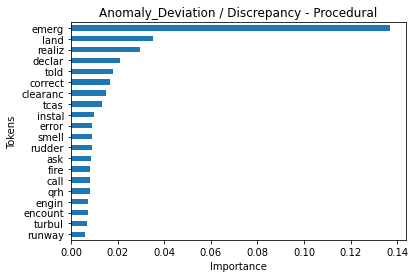

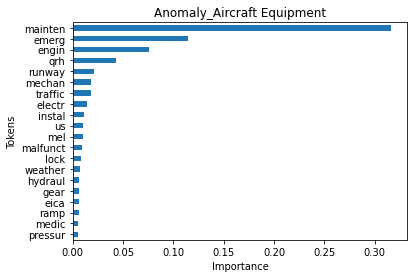

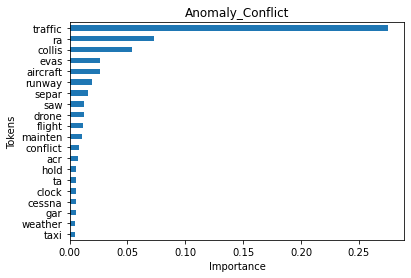

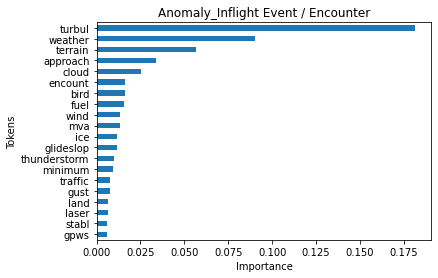

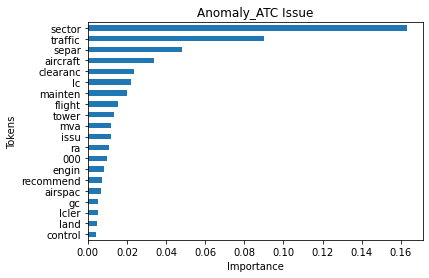

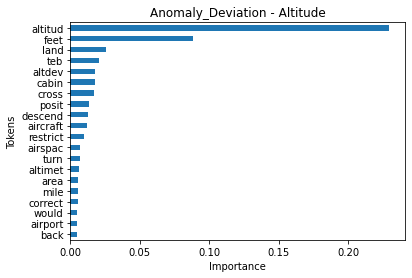

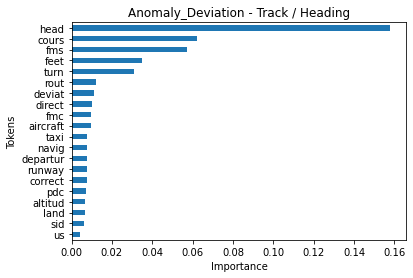

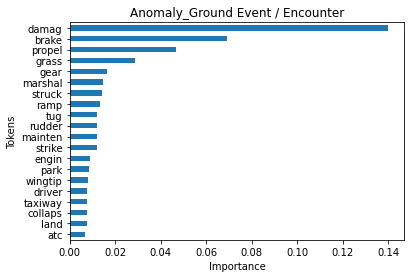

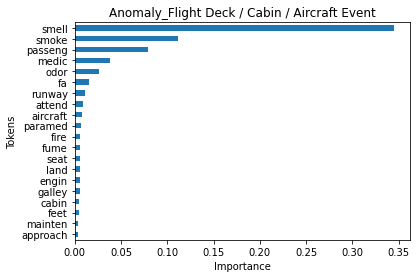

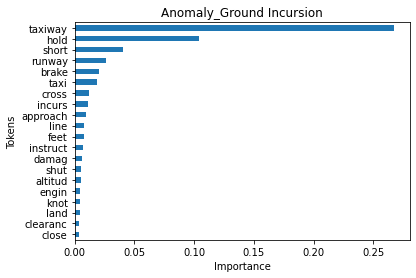

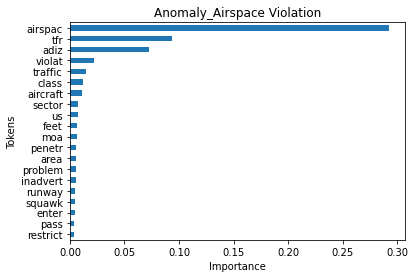

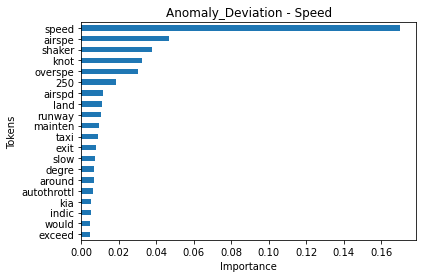

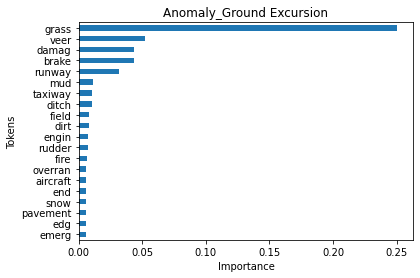

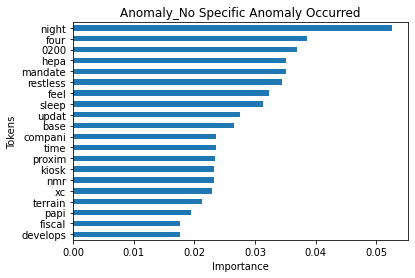

In [17]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(20)
  topfeatures.set_index('token').plot.barh(  y=[col_importance],legend=None) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly)


### Dictionnary : Token Importance 

In [18]:
vocab_length_list=[20,30,50,100,250,500,750,1000,3000]

In [19]:
# Defines a dictionnary (keys = anomalies) of dictionnaries (keys=vocab_length) of top N important tokens for the anomaly
dict_top_N_features={}
for Anomaly in Anomaly_RootLabels_columns:
  col_importance = 'Importance_' + Anomaly
  dict_top_features={}
  for vocab_length in vocab_length_list :
    topfeatures = list(df_importances.sort_values(by = col_importance, ascending = False).head(vocab_length)['token'])
    dict_top_features[vocab_length]=topfeatures
  dict_top_N_features[Anomaly]=dict_top_features

#### Analysis of top most important tokens / anomaly 

In [20]:
# Defines a dictionnary (keys = vocab_length) of top N important  tokens for all the anomalies (deduplicated)
# i.e :  For 20 : we take the 20 most important tokens for each anomalies (potentially 280 tokens) and deduplicate the list : we get 189 tokens
dict_top_N_features_global={}
for vocab_length in vocab_length_list :
  vocab_total_list=[]
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]  
    vocab_total_list=vocab_total_list+liste
  vocab_distinct_list=list(set(vocab_total_list))  
  dict_top_N_features_global[vocab_length]=vocab_distinct_list

In [21]:
for vocab_length in vocab_length_list :
  print('Top ',vocab_length,' most important tokens (per anomaly) =>', len(dict_top_N_features_global[vocab_length]), 'tokens in total')

Top  20  most important tokens (per anomaly) => 187 tokens in total
Top  30  most important tokens (per anomaly) => 265 tokens in total
Top  50  most important tokens (per anomaly) => 398 tokens in total
Top  100  most important tokens (per anomaly) => 691 tokens in total
Top  250  most important tokens (per anomaly) => 1548 tokens in total
Top  500  most important tokens (per anomaly) => 2915 tokens in total
Top  750  most important tokens (per anomaly) => 3981 tokens in total
Top  1000  most important tokens (per anomaly) => 4870 tokens in total
Top  3000  most important tokens (per anomaly) => 7012 tokens in total


## SECOND DECISION TREE

### SECOND DT (Gini , Max_Depth=20), PP NARRATIVES,DEFAULT SAMPLING  , Vocab = N most important tokens (df_metrics_DT_PP_Impce_N.pkl) 

In [22]:
# Saves the metrics into a pkl file
import pickle

In [23]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000]  

In [24]:
vocab_length_list_to_run=[20,30] 

In [25]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    # Initializes the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    clf = DecisionTreeClassifier(max_depth = 20)
    vectorizer = CountVectorizer(vocabulary=liste) 

    # Calls the function 
    df_second_metrics, df_second_importances = metrics_table_DT(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]
    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
  filename = 'df_metrics_DT_PP_Impce_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Aircraft Equipment
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Conflict
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Inflight Event / Encounter
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_ATC Issue
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation - Altitude
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation - Track / He

## OTHER CLASSIFIERS

## FUNCTIONS

### STANDARD SAMPLING - Function metrics_table (all classifiers)
-Performs a model with standard sampling on the different targets and stock the results  

In [ ]:
def metrics_table(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
     
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp 

### UNDERSAMPLING - Function metrics_table_US (for all classifiers)
-Performs a model with under sampling on the different targets and stock the results

In [ ]:
def metrics_table_US(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier  
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # add an extra column ones in the data DataFrame for convenience later during undersampeling
    data = pd.DataFrame(data)
    data['ones'] = 1

    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # Remove from X_test
    X_test = X_test.drop('ones', axis=1)
    X_test = X_test.squeeze()
    
    # Instantiate variables
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]

      # Perform an undersampeling step
      rus = RandomUnderSampler()
      X_ru, y_ru = rus.fit_resample(X_train, y_train_Anomaly)

      # Remove the extra added column of ones from the X_ru and X_test 
      # Remove from X_ru
      X_ru = X_ru.drop('ones', axis=1)
      X_ru = X_ru.squeeze()

      # apply the vectorizer 
      X_ru = vectorizer.fit_transform(X_ru) 
      X_test_Anomaly = vectorizer.transform(X_test) 
      vocab = vectorizer.get_feature_names_out()
      print("Vocabulary length:" , len(vocab))

      # Train & predict
      classifier.fit(X_ru, y_ru)
      y_pred = classifier.predict(X_test_Anomaly)


      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['undersampling'] = 1  # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp

## RANDOM FOREST

### RF DEFAULT SAMPLING (df_metrics_RF_PP_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
#target = df[['Anomaly_Aircraft Equipment']]
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 9140
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 27.8 minutes ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
filename = 'df_metrics_RF_PP_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### RF DEFAULT SAMPLING (df_metrics_RF_PP_Impce_N.pkl)
PP NARRATIVES, Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
# vocab_length_list_to_run=[20,30,50,100,250,500,750,1000] 

In [ ]:
vocab_length_list_to_run=[20,30] # à faire

In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
  filename = 'df_metrics_RF_PP_Impce_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
--- DONE! It took 0.9 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Aircraft Equipment
--- DONE! It took 0.6 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Conflict
--- DONE! It took 0.7 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Inflight Event / Encounter
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_ATC Issue
--- DONE! It took 0.8 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation - Altitude
--- DONE! It took 0.6 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation - Track / He

### RF UNDER SAMPLING (df_metrics_RF_PP_US_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 


In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_US(data, target, vectorizer, clf)


------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 8208
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 8128
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 5726
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 5963
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 5618
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 4297
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 4354
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 4163
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 4201
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 3405
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 3310
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 2662
Prediction of anomaly 

In [ ]:
df_metrics.head()

,metric,0,1,accuracy,macro avg,weighted avg,anomaly,undersampling
0,precision,0.675310,0.796790,0.746314,0.736050,0.748274,Anomaly_Deviation / Discrepancy - Procedural,1
1,recall,0.702595,0.775384,0.746314,0.738989,0.746314,Anomaly_Deviation / Discrepancy - Procedural,1
2,f1-score,0.688682,0.785941,0.746314,0.737312,0.747099,Anomaly_Deviation / Discrepancy - Procedural,1
3,support,7747.000000,11651.000000,0.746314,19398.000000,19398.000000,Anomaly_Deviation / Discrepancy - Procedural,1
4,precision,0.910672,0.829777,0.877255,0.870224,0.878702,Anomaly_Aircraft Equipment,1


In [ ]:
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
filename = 'df_metrics_RF_PP_US_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### RF UNDER SAMPLING (df_metrics_RF_PP_US_Impce_N.pkl)
PP NARRATIVES, Vocab = N most important tokens 

In [ ]:
# vocab_length_list_to_run=[20,30,50,100,250,500,750,1000] 

In [ ]:
vocab_length_list_to_run=[250,500,750,1000] # à faire

In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics = metrics_table_US(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
  filename = 'df_metrics_RF_PP_US_Impce_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 250
--- DONE! It took 2.3 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 250
--- DONE! It took 1.7 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 250
--- DONE! It took 0.6 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 250
--- DONE! It took 0.6 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 250
--- DONE! It took 0.5 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 250
--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary

## GRADIENT BOOSTING

### GRADIENT BOOSTING  DEFAULT SAMPLING (df_metrics_RF_PP_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
#target = df[['Anomaly_Aircraft Equipment']]
clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Gradient Boosting'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 9140
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 6.2 minutes ---


In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
filename = 'df_metrics_GB_PP_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### GRADIENT BOOSTING DEFAULT SAMPLING (df_metrics_GB_PP_Impce_N.pkl) 
PP NARRATIVES Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
# vocab_length_list_to_run=[20,30,50,100,250,500,750,1000] 

In [ ]:
vocab_length_list_to_run=[250,500,750,1000] # à faire

In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Gradient Boosting'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
  filename = 'df_metrics_GB_PP_Impce_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_Aircraft Equipment
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_Conflict
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_Inflight Event / Encounter
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_ATC Issue
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_Deviation - Altitude
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_Deviation - Tra

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Vocabulary length: 250
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 0.1 minutes ---
(56, 11)  should be (56 , 11)
/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection
------- Execution started... ------- 

Vocabulary length: 500
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 500
Prediction of anomaly : Anomaly_Aircraft Equipment
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 500
Prediction of anomaly : Anomaly_Conflict
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 500
Prediction of anomaly : Anomaly_Inflight Event / Encounter
--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 500
Prediction of anomaly : Anomal

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 500
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 0.1 minutes ---
(56, 11)  should be (56 , 11)
/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection
------- Execution started... ------- 

Vocabulary length: 750
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 750
Prediction of anomaly : Anomaly_Aircraft Equipment
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 750
Prediction of anomaly : Anomaly_Conflict
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 750
Prediction of anomaly : Anomaly_Inflight Event / Encounter
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 750
Prediction of anomaly : Anomal

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 750
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 0.1 minutes ---
(56, 11)  should be (56 , 11)
/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection
------- Execution started... ------- 

Vocabulary length: 1000
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 1000
Prediction of anomaly : Anomaly_Aircraft Equipment
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 1000
Prediction of anomaly : Anomaly_Conflict
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 1000
Prediction of anomaly : Anomaly_Inflight Event / Encounter
--- DONE! It took 0.4 minutes ---
------- Execution started... ------- 

Vocabulary length: 1000
Prediction of anomaly : A

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- DONE! It took 0.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 1000
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 0.1 minutes ---
(56, 11)  should be (56 , 11)
/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### GRADIENT BOOSTING UNDER SAMPLING (df_metrics_RF_PP_US_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 


In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_US(data, target, vectorizer, clf)


------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 8197
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 8100
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 5710
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 5962
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 5601
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 4302
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 4399
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 4191
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 4203
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 3355
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 3322
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 2639
Prediction of anomaly 

In [ ]:
df_metrics.head()

,metric,0,1,accuracy,macro avg,weighted avg,anomaly,undersampling
0,precision,0.619756,0.794611,0.712754,0.707183,0.724779,Anomaly_Deviation / Discrepancy - Procedural,1
1,recall,0.726475,0.703631,0.712754,0.715053,0.712754,Anomaly_Deviation / Discrepancy - Procedural,1
2,f1-score,0.668885,0.746358,0.712754,0.707622,0.715418,Anomaly_Deviation / Discrepancy - Procedural,1
3,support,7747.000000,11651.000000,0.712754,19398.000000,19398.000000,Anomaly_Deviation / Discrepancy - Procedural,1
4,precision,0.893760,0.823838,0.865605,0.858799,0.866127,Anomaly_Aircraft Equipment,1


In [ ]:
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Gradient Boosting'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
filename = 'df_metrics_GB_PP_US_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### GRADIENT BOOSTING UNDER SAMPLING (df_metrics_GB_PP_US_Impce_N.pkl) 
PP NARRATIVES Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
# vocab_length_list_to_run=[20,30,50,100,250,500,750,1000] 

In [ ]:
vocab_length_list_to_run=[250,500,750,1000] # à faire

In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table_US(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Gradient Boosting'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection/
  filename = 'df_metrics_GB_PP_US_Impce_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 250
--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 250
--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary